## Tarea 10 del curso CM-072

* Nombre y apellidos:
* Fecha de presentación: 8 de diciembre.

Conjunto de librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


En este ejercicio realizamos Análisis de Componentes Principales (PCA) en el conjunto de datos `USArrests`. Para cada uno de los 50 estados de los EE.UU., el conjunto de datos contiene el número de arrestos por cada 100,000 residentes para cada uno de tres crímenes: Asalto (`Assault`), Asesinato (`Murder`) y Violación (`Rape`). También se registra la variable `UrbanPop` (porcentaje de la población en cada estado que vive en las áreas urbanas).

Las filas del conjunto de datos contienen los 50 estados, en orden alfabético.

In [2]:
df = pd.read_csv('USArrests.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
Murder      50 non-null float64
Assault     50 non-null int64
UrbanPop    50 non-null int64
Rape        50 non-null float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [3]:
df.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


Vemos de inmediato que los datos tienen valores medios **notablemente** diferentes. También podemos examinar la media y la varianza de las cuatro variables:

In [4]:
df.mean()

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

In [5]:
df.var()

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

Como podría haberse esperado, las variables tienen también varianzas notablemente diferentes: la variable `UrbanPop` mide el porcentaje de la población en cada estado que vive en un área urbana, número que no es comparable con el número de crímenes cometidos en cada estado por cada 100,000 individuos. Si dejásemos de escalar las variables antes de realizar PCA, la mayoría de los componentes principales que observaríamos estarían sesgados hacia la variable `Assault`, pues ésta tiene ampliamente la mayor media y la mayor varianza.

Así pues, es importante estandarizar las variables con una media de cero y una desviación estándar de 1 antes de realizar PCA. Podemos hacerlo usando la función `scale` de `sklearn`, que es el equivalente:

```
# La función scale es equivalente a:
# X = (df - np.mean(df, axis=0)) / np.std(df, axis=0)
```

In [6]:
from sklearn.preprocessing import scale
X = scale(df)

Visualicemos los primeros 5 estados de `X` en un dataframe:

In [7]:
pd.DataFrame(X, index=df.index, columns=df.columns).head()

,Murder,Assault,UrbanPop,Rape
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794
California,0.281093,1.275635,1.776781,2.088814


Ahora usaremos la función `PCA()` de `sklearn` para calcular los vectores de cargas *(loadings)*, es decir, los coeficientes que cada variable aporta a cada uno de los componentes principales. Una vez ajustado el modelo, los vectores de carga pueden recuperarse con el atributo `components_`:

In [8]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
pca_loadings = pca.components_
pd.DataFrame(pca_loadings, columns=df.columns, index=['PC1', 'PC2', 'PC3', 'PC4']).head()

,Murder,Assault,UrbanPop,Rape
PC1,0.535899,0.583184,0.278191,0.543432
PC2,0.418181,0.187986,-0.872806,-0.167319
PC3,-0.341233,-0.268148,-0.378016,0.817778
PC4,0.649228,-0.743407,0.133878,0.089024


Vemos que hay cuatro componentes principales. Esto es de esperarse, porque hay en general $min(n-1, p)$ componentes principales informativos en un conjunto de datos de $n$ observaciones y $p$ variables.

La matriz de vectores de cargas es a veces denominada *matriz de rotación*, porque cuando multiplicamos la matriz X por la transpuesta de la matriz de cargas, nos da las coordenadas de los datos en el sistema de coordenadas rotado. Estas coordenadas son los puntajes *(scores)* de los componentes principales.

Usando la función `transform` de `sklearn`, no necesitamos multiplicar explícitamente los datos por los vectores de carga de los componentes principales para obtener los vectores de puntaje de los componentes principales. La función `transform` nos devuelve una matriz de dimensiones 50 x 4 cuyas columnas son los vectores de puntaje de los componentes principales. Es decir, la k-ésima columna corresponde al vector de puntajes del k-mo componente principal.

In [9]:
pca_scores = pca.transform(X)

In [10]:
# Visualizamos los puntajes para los primeros estados
df_plot = pd.DataFrame(pca_scores, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=df.index)
df_plot.head()

,PC1,PC2,PC3,PC4
Alabama,0.985566,1.133392,-0.444269,0.156267
Alaska,1.950138,1.073213,2.040003,-0.438583
Arizona,1.763164,-0.745957,0.054781,-0.834653
Arkansas,-0.141420,1.119797,0.114574,-0.182811
California,2.523980,-1.542934,0.598557,-0.341996


Como podemos verificar, es posible recuperar por completo el conjunto de datos inicial multiplicando la matriz de puntajes $(U \Sigma)$ por la matriz de cargas $(V^\top)$.

In [11]:
X_rec = np.dot(pca_scores, pca_loadings)
pd.DataFrame(X_rec, index=df.index, columns=df.columns).head()

,Murder,Assault,UrbanPop,Rape
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794
California,0.281093,1.275635,1.776781,2.088814


Definamos una función para construir un **biplot** de los dos primeros componentes principales.

In [12]:
def biplot(loadings, scores, index, columns):
    fig , ax1 = plt.subplots(figsize=(9,7))

    ax1.set_xlim(-3.5,3.5)
    ax1.set_ylim(-3.5,3.5)

    # Nombre de cada estado ubicado por puntajes para cada componente principal
    for i, index in enumerate(index):
        ax1.annotate(index, (scores[i, 0], scores[i, 1]), ha='center', color='blue')

    # Líneas de referencia
    ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
    ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

    ax1.set_xlabel('Primer Componente Principal')
    ax1.set_ylabel('Segundo Componente Principal')

    # Diagramar los vectores de cargas, superponiendo un segundo eje x, y
    ax2 = ax1.twinx().twiny() 

    ax2.set_ylim(-1,1)
    ax2.set_xlim(-1,1)
    ax2.set_xlabel('Vectores de cargas de los componentes principales', color='red')

    # Vectores de carga
    # La variable 'a' es un pequeño offset para separar las etiquetas de las flechas
    a = 1.07  
    for i, column in enumerate(columns):
        ax2.annotate(column, (loadings[0,i]*a, loadings[1,i]*a), color='red')
        ax2.arrow(0, 0, loadings[0,i], loadings[1,i], color='red')
    plt.show()

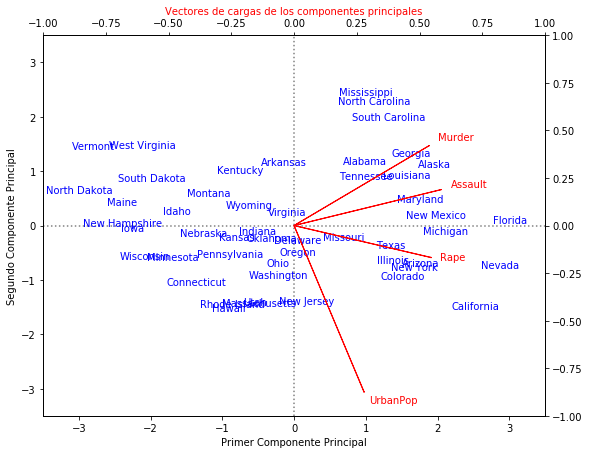

In [13]:
biplot(loadings=pca_loadings, scores=pca_scores, index=df.index, columns=df.columns)

Tal vez hayas notado que esta figura tiene el segundo componente principal "en espejo" con respecto a la Figura 4 que vimos en clase. Recuerda que los componentes principales son únicos salvo por el cambio de signo. Podemos reproducir la Figura 4 con un par de pequeños cambios:

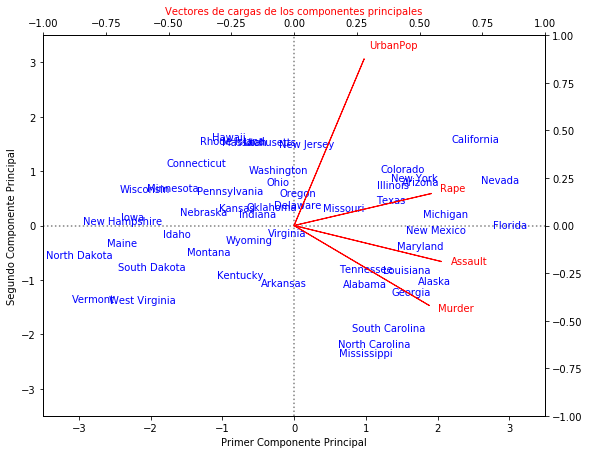

In [14]:
pca_loadings[1,:] = -pca_loadings[1,:]
pca_scores[:,1] = -pca_scores[:,1]

biplot(loadings=pca_loadings, scores=pca_scores, index=df.index, columns=df.columns)

La función `PCA()` también nos brinda la varianza explicada por cada componente principal. Podemos acceder a estos valores como sigue:

In [15]:
explained_variance = pca.explained_variance_
print('Varianza explicada por cada componente principal:')
print(explained_variance)

Varianza explicada por cada componente principal:
[2.53085875 1.00996444 0.36383998 0.17696948]


También podemos obtener la proporción de varianza explicada por cada componente principal:

In [16]:
PVE = pca.explained_variance_ratio_
print('Proporción de varianza explicada (PVE) por cada componente principal:')
print(PVE)

Proporción de varianza explicada (PVE) por cada componente principal:
[0.62006039 0.24744129 0.0891408  0.04335752]


Podemos ver que el primer componente principal explica 62.0% de la varianza en los datos, el siguiente componente principal explica el 24.7% de la varianza, y así en adelante. Podemos diagramar la proporción de varianza explicada (PVE) por cada componente, como sigue:

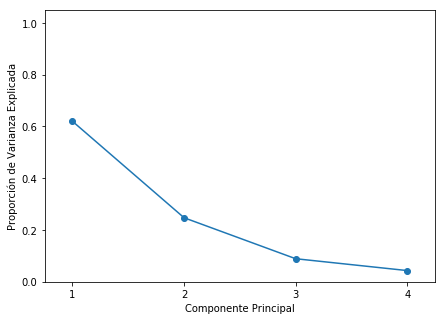

In [17]:
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4], pca.explained_variance_ratio_, '-o')
plt.ylabel('Proporción de Varianza Explicada')
plt.xlabel('Componente Principal')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4])
plt.show()

También podemos usar la función `numpy.cumsum()`, que calcula la suma acumulada de los elementos de un vector numérico, para diagramar la PVE acumulada:

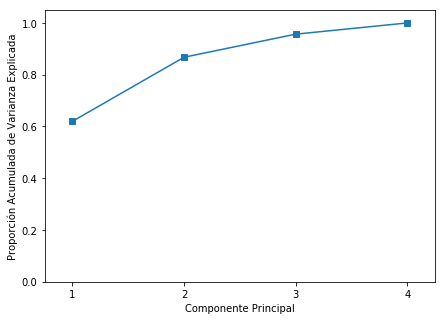

In [18]:
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4], np.cumsum(pca.explained_variance_ratio_), '-s')
plt.ylabel('Proporción Acumulada de Varianza Explicada')
plt.xlabel('Componente Principal')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4])
plt.show()

1. Completa el siguiente ejercicio

Empezaremos con un conjunto de datos en 2D que tiene mucha varianza en una dirección y menor variación en la otra. A continuación cargaremos y visualizaremos el conjunto de datos. En esta parte del ejercicio visualizarás lo que ocurre cuando reduces los datos de 2D a 1D. En la práctica, querrás reducir datos de 256 a 50 dimensiones, por decir algo; pero usar datos en menores dimensiones, como en este ejemplo, nos permite visualizar mejor los algoritmos.

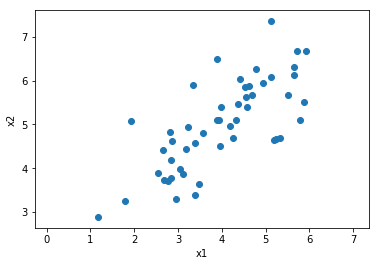

In [19]:
from scipy.io import loadmat
ex7data1 = loadmat('ex7data1.mat')
X = np.array(ex7data1['X'])
plt.axes().set_aspect('equal', 'datalim')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X[:,0], X[:,1], marker='o', cmap='prism')
plt.show()

Como hemos visto, es importante normalizar primero los datos sustrayendo el valor medio de cada característica del conjunto de datos y escalando cada dimensión para que todas estén en el mismo rango. Es lo que hacemos a continuación:

In [20]:
from sklearn.preprocessing import scale 
X_norm = scale(X)

Veamos cómo los datos se encuentran ahora normalizados:

In [21]:
# Comparemos los datos con y sin normalización:
print('Antes de normalizar:\n', X[:5])
print('\nDespués de normalizar:\n', X_norm[:5])

Antes de normalizar:
 [[3.38156267 3.38911268]
 [4.52787538 5.8541781 ]
 [2.65568187 4.41199472]
 [2.76523467 3.71541365]
 [2.84656011 4.17550645]]

Después de normalizar:
 [[-0.52331306 -1.59279252]
 [ 0.46381518  0.84034523]
 [-1.14839331 -0.58315891]
 [-1.05405373 -1.27071783]
 [-0.98402167 -0.81658417]]


Una vez que los datos están normalizados, puedes ejecutar PCA para calcular los componentes principales. Tu tarea es completar el código que sigue para calcular el vector de cargas del conjunto de datos normalizado.

In [22]:
pca2 = PCA().fit(X_norm)
pca2_loadings = pca2.components_

print('El vector de cargas del primer componente principal es:')
print(pca2_loadings[0,:])

El vector de cargas del primer componente principal es:
[-0.70710678 -0.70710678]


Graficamos la dirección de los dos primeros componentes principales:

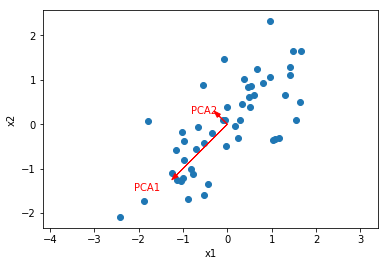

In [23]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(X_norm[:,0], X_norm[:,1], marker='o', cmap='prism')
plt.xlabel('x1')
plt.ylabel('x2')
a = 1.2
plt.annotate('PCA1', (pca2_loadings[0,0]*pca2.explained_variance_[0]*a, pca2_loadings[0,1]*pca2.explained_variance_[0]*a), color='red', ha='right')
plt.arrow(0,0, pca2_loadings[0,0]*pca2.explained_variance_[0], pca2_loadings[0,1]*pca2.explained_variance_[0], color='r', head_width=0.1, length_includes_head=True)
plt.annotate('PCA2', (pca2_loadings[1,0]*pca2.explained_variance_[1]*a, pca2_loadings[1,1]*pca2.explained_variance_[1]*a), color='red', ha='right')
plt.arrow(0,0, pca2_loadings[1,0]*pca2.explained_variance_[1], pca2_loadings[1,1]*pca2.explained_variance_[1], color='r', head_width=0.1, length_includes_head=False)
plt.show()




Después de calcular los componentes principales, puedes usarlos para reducir la dimensión de características de tu conjunto de datos proyectando cada ejemplo sobre un espacio de menores dimensiones, $x^{(i)} \rightarrow z^{(i)}$ (p.ej., proyectando los datos de 2D a 1D).

En la práctica, si estuvieses usando un algoritmo de aprendizaje tal como regresión lineal o quizás redes neuronales, podrías usar los datos proyectados en lugar de los datos originales. Usando los datos proyectados, puedes entrenar tu modelo más rápido pues hay menos dimensiones en los datos de entrada.

Para proyectar los datos sólo necesitas truncar las primeras `K` columnas de la matriz de puntajes.

In [24]:
def projectData(pcaModel, X, K):
    Z = pcaModel.transform(X)[:,:K]
    return Z

In [25]:
# Proyectamos los datos
Z = projectData(pca2, X_norm, 1)
print('La proyección del primer ejemplo sobre la primera dimensión es: %0.5f' % Z[0,0])

La proyección del primer ejemplo sobre la primera dimensión es: 1.49631


Luego de proyectar los datos en un espacio de menores dimensiones, puedes recuperar aproximadamente los datos proyectándolos de regreso en el espacio original de alta dimensión. Para hacerlo, multiplicamos Z por las primeras `K` filas de la matriz de carga.

In [26]:
def recoverData(pcaModel, Z):
    K = Z.shape[1]
    X_rec = np.dot(Z, pcaModel.components_[:K,:])
    return X_rec

In [27]:
X_rec = recoverData(pca2, Z)

Una vez realizada la proyección y reconstrucción aproximada de los datos, veamos en el siguiente diagrama cómo la proyección afecta los datos. Los puntos de datos originales están indicados con color azul, mientras que los puntos de datos proyectados están indicados con color rojo. La proyección retiene efectivamente la información en la dirección del primer componente principal.

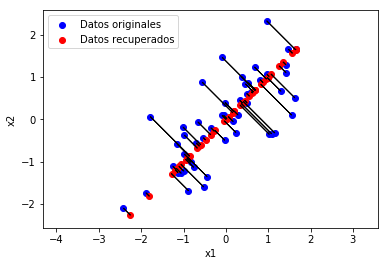

In [28]:
plt.axes().set_aspect('equal', 'datalim')
for i in range(X_norm.shape[0]):
    plt.arrow(X_norm[i,0], X_norm[i,1], X_rec[i,0]-X_norm[i,0], X_rec[i,1]-X_norm[i,1], color='k')
plt.scatter(X_norm[:,0], X_norm[:,1], marker='o', c='blue', label='Datos originales')  
plt.scatter(X_rec[:,0], X_rec[:,1], marker='o', c='red', label='Datos recuperados')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')
plt.show()

En esta parte del ejercicio, aplicarás PCA a imágenes de rostros para ver cómo puede se puede usar PCA en la práctica para reducción de la dimensionalidad. El archivo `ex7faces.mat` contiene un conjunto de datos `X` con imagénes de 32 x 32 pixeles en tonos de grises. Cada fila corresponde a una imagen (un vector fila de longitud 1024). En el siguiente paso cargaremos `X` y visualizaremos las primeras 100 imágenes.

In [29]:
from scipy.io import loadmat

ex7faces = loadmat('ex7faces.mat')
X = np.array(ex7faces['X'])

In [30]:
from matplotlib.pyplot import figure, imshow, axis

def mostrarImagenes(X, num_cols, shape, title='asdf'):
    num_imagenes = X.shape[0]
    num_filas = np.ceil(num_imagenes / num_cols)
    fig = figure()
    fig.set_size_inches(10, 10)

    for i in range(num_imagenes):
        a=fig.add_subplot(num_filas, num_cols, i +1)
        image = X[i,:].reshape(shape).T
        imshow(image,cmap='Greys_r')
        axis('off')

Imágenes originales


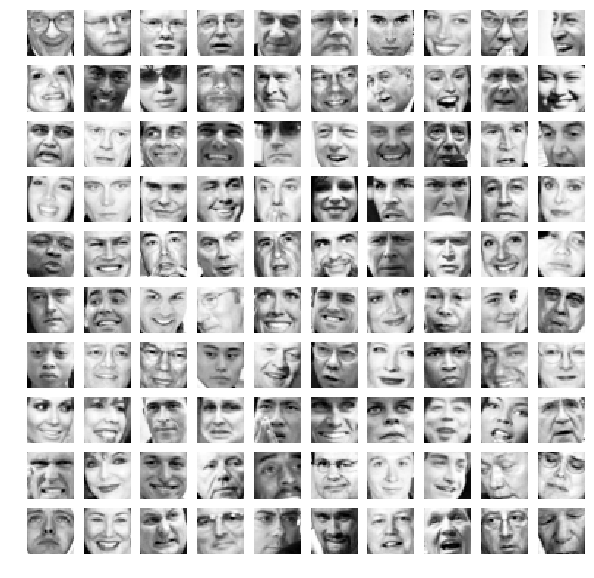

In [31]:
print('Imágenes originales')
mostrarImagenes(X[:100], 10, [32, 32])

Antes de ejecutar PCA en el conjunto de datos, normaliza el conjunto de datos usando la función `scale`. 

Luego ajusta un modelo PCA a los datos. Observa que cada fila de la matriz de cargas es un vector de longitud $n$ (para el dataset, $n = 1024$).

Resulta que podemos visualizar estos componentes principales transformando cada uno de ellos en una matriz `32 x 32` que corresponde a los pixeles del conjunto de datos original. Una vez que hayas ajustado el modelo PCA, mostraremos los primeros 36 componentes principales que describen la mayor varianza. 

Si deseas, modifica el código para mostrar más componentes principales y ver cómo capturan cada vez más detalles.

1 .Completa el siguiente código

```
from sklearn.preprocessing import scale 

## COMPLETAR...
X_norm = ...
pca_faces = ...
pca_faces_loadings = ...
print('Carga de los primeros 36 componentes principales')
mostrarImagenes(pca_faces_loadings[:36,:], num_cols=6, shape=[32, 32])
```

In [32]:
# Tu solucion

Ahora que has calculado los principales componentes del conjunto de datos de rostros, puedes usarlos para reducir su dimensionalidad. Esto te permite entrenar tu algoritmo de aprendizaje con un tamaño de entradas menor (p.ej., 100 dimensiones) en lugar de las 1024 dimensiones originales. Esto puede ayudar a acelerar tu algoritmo de aprendizaje.

En la siguiente parte proyectarás el conjunto de datos sobre solamente los primeros 100 componentes principales. Específicamente, cada imagen quedará descrita por un vector $z^{(i)} \in \mathbb{R}^{100}$.

Para entender lo que se pierde en la reducción de dimensionalidad, recuperarás las imágenes a partir de los datos proyectados.

Una vez que hayas calculado las proyecciones y la recuperación de los datos, visualizaremos las imágenes reconstruidas. En la reconstrucción podrás observar que se conserva la estructura general y apariencia de los rostros, y se pierde los detalles más finos. Esta es una notable reducción (más de 10x) en el tamaño del conjunto de datos, que puede ayudar a acelerar significativamente tu algoritmo de aprendizaje. Por ejemplo, si estuvieses entrenando una red neuronal para realizar reconocimiento de personas (dada la imagen de un rostro, identificar a la persona), puedes usar la entrada reducida a 100 dimensiones en lugar de los pixeles originales.

2 .Completa el siguiente código.

```
## COMPLETAR...
# Proyecta los datos sobre los primeros 100 componentes principales
Z = projectData(...)

# Recupera los datos a partir de la proyección
X_rec = recoverData(...)
print('Imágenes reconstruidas')
mostrarImagenes(X_rec[:100], 10, [32, 32])
```

In [33]:
# Tu solucion

3 .¿Cuál es la proporción acumulada de varianza explicada por los primeros 100 componentes principales del conjunto de datos de rostros? (Redondear a 4 decimales).

In [34]:
# Tu solucion

4 .¿Puedes graficar la proporción acumulada de varianza explicada por PCA para este conjunto de datos?.

In [35]:
# tu solucion